# LR Range for Depthwise Training

We manually search for the appropriate hyperparameter (LR) range for
fine-tuning at DEPTH_INDEX = 1, using vgg16 and inception_resnet_v2

In [10]:
#!/usr/bin/env python
# coding: utf-8
import pickle
import matplotlib as mpl
from matplotlib import pyplot as plt
import pandas as pd
import os

# Don't display mpl windows (will cause error in non-gui environment)
mpl.use("Agg")

import keras
import traceback

import core.history as ch
from core.fine_model import FineModel

import cr_interface as cri

from lib import notify
import results
import analysis
import stats

from params import (BATCH_SIZE, K, SAVE_ALL_WEIGHTS, T, BALANCE,
                    LEARNING_RATES, DEPTH_INDEX, EPOCHS, SAMPLE, K_SPLIT_SEED, MODEL_KEYS,
                    LR_INDEX, FOLD_INDEX, USE_MULTIPROCESSING,
                    MULTIPROCESSING_WORKERS)

In [11]:
%matplotlib inline

### Load Data

In [ ]:
SAMPLE = None

train = cri.CrCollection.load().filter_by(dataset_index=0).tri_label().labeled()
if SAMPLE and SAMPLE != 1:
    print("Sampling {:.0%} of original training dataset".format(SAMPLE))
    train = train.sample(frac=SAMPLE)
folds = train.k_split(K, seed=K_SPLIT_SEED)

stats.print_collection_stats(train, "Training/Validation Set")
stats.print_fold_stats(folds)

### Load Model and Image Data Generators

In [ ]:
model_key = "vgg16"
fm = FineModel.get_dict()[model_key]()
fm.get_model()
train_gens, val_gens = fm.get_train_val_generators(folds, augment_factor=BALANCE)
train_gen, val_gen = train_gens[0], val_gens[0]  # consider one fold

### Get Results Per LR

In [ ]:
def test_lr(fm, lr, train_gen, val_gen, epochs):
    depth_index = 1
    previous_instance_key = "D{:02d}_FINAL".format(depth_index - 1)
    fm.load_weights(previous_instance_key)
    fm.set_depth(1)
    fm.compile_model(lr=lr)
    
    result = fm.get_model().fit_generator(
        train_gen,
        validation_data=val_gen,
        steps_per_epoch=len(train_gen),
        validation_steps=len(val_gen),
        workers=MULTIPROCESSING_WORKERS,
        use_multiprocessing=USE_MULTIPROCESSING,
        shuffle=True,
        epochs=epochs
    )
    
    return result

In [ ]:
results_by_lr = {}
for lr in [1.0e-3, 1.0e-4, 1.0e-5, 1.0e-6, 1.0e-7]:
    results_by_lr[lr] = test_lr(fm, lr, train_gen, val_gen, epochs=20)
rblr_vgg16 = results_by_lr

### Notes

- 1.0e-2 causes NaN loss at initial steps
- 1.0e-3 loss dips to ~1.0 in initial steps, suggesting complete loss of transferred features.
  - NaN loss occurs for some runs
- 1.0e-4 no loss dip observed

In [ ]:
RESULTS_BY_LR_VGG16 = "temp_rblr_vgg16.pickle"
with open(RESULTS_BY_LR_VGG16, "wb") as f:
    pickle.dump(rblr_vgg16, f)

### Get Results For inception_resnet_v2

In [ ]:
model_key = "inception_resnet_v2"
fm = FineModel.get_dict()[model_key]()
fm.get_model()
train_gens, val_gens = fm.get_train_val_generators(folds, augment_factor=BALANCE)
train_gen, val_gen = train_gens[0], val_gens[0]  # consider one fold

In [ ]:
results_by_lr = {}
for lr in [1.0e-3, 1.0e-4, 1.0e-5, 1.0e-6, 1.0e-7]:
    results_by_lr[lr] = test_lr(fm, lr, train_gen, val_gen, epochs=20)
rblr_incresv2 = results_by_lr

In [ ]:
RESULTS_BY_LR_INCRESV2 = "temp_rblr_incresv2.pickle"
with open(RESULTS_BY_LR_INCRESV2, "wb") as f:
    pickle.dump(rblr_incresv2, f)

## Visualize History By LR

For mobilenet_a25 and inception_resnet_v2

### Reload Cached Results

In [3]:
RESULTS_BY_LR_VGG16 = "temp_rblr_vgg16.pickle"
RESULTS_BY_LR_INCRESV2 = "temp_rblr_incresv2.pickle"
with open(RESULTS_BY_LR_VGG16, "rb") as f:
    rblr_vgg16 = pickle.load(f)
with open(RESULTS_BY_LR_INCRESV2, "rb") as f:
    rblr_incresv2 = pickle.load(f)

W0609 08:18:14.963837 140490122127168 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4070: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0609 08:18:17.500821 140490122127168 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.

W0609 08:18:18.931066 140490122127168 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4074: The name tf.nn.avg_pool is deprecated. Please use tf.nn.avg_pool2d instead.



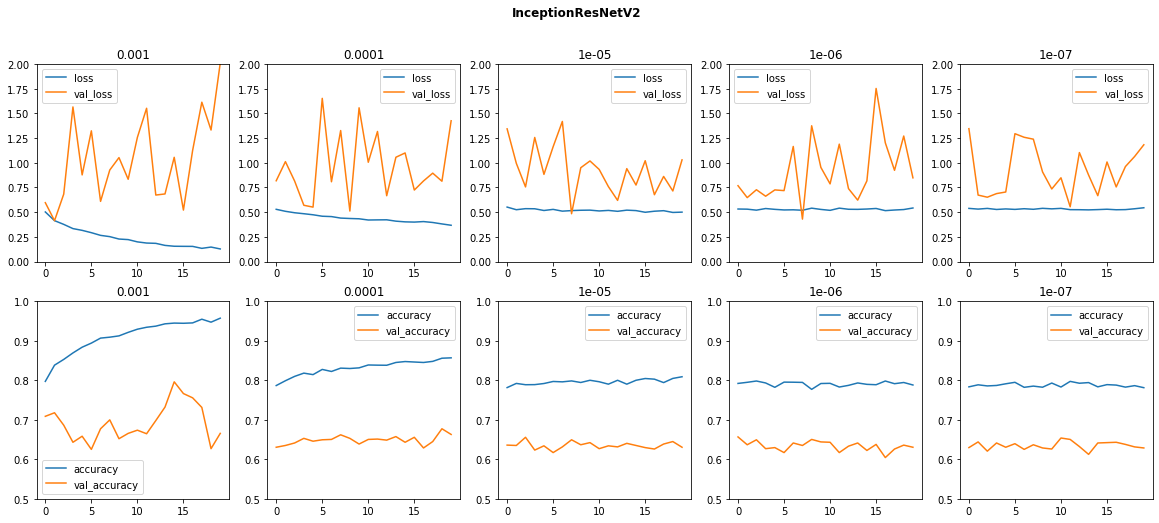

In [12]:
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
fig.suptitle("InceptionResNetV2", fontweight="bold")
for ax, item in zip(axes[0], rblr_incresv2.items()):
    lr, result = item
    pd.DataFrame(result.history).loc[:,["loss", "val_loss"]].plot(ax=ax)
    ax.legend()
    ax.set_ylim(0, 2)
    ax.set_title(lr)
    
for ax, item in zip(axes[1], rblr_incresv2.items()):
    lr, result = item
    pd.DataFrame(result.history).loc[:,["accuracy", "val_accuracy"]].plot(ax=ax)
    ax.legend()
    ax.set_ylim(0.5, 1)
    ax.set_title(lr)
    
os.makedirs("figures", exist_ok=True)
fig.savefig(os.path.join("figures", "Fine Tune LR Range (InceptionResNetV2).png"), dpi=320)

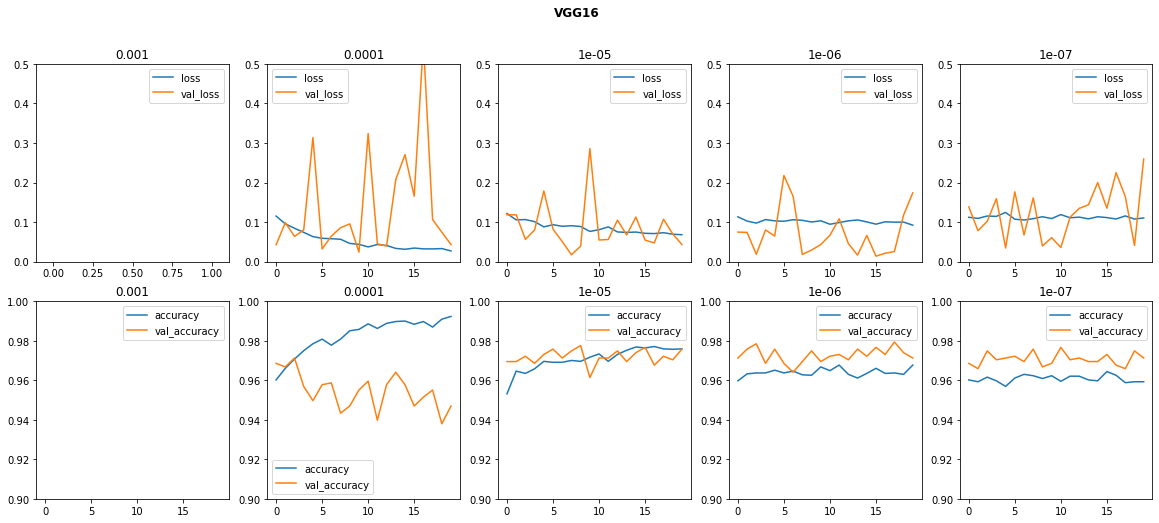

In [13]:
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
fig.suptitle("VGG16", fontweight="bold")
for ax, item in zip(axes[0], rblr_vgg16.items()):
    lr, result = item
    pd.DataFrame(result.history).loc[:,["loss", "val_loss"]].plot(ax=ax)
    ax.legend()
    ax.set_ylim(0, 0.5)
    ax.set_title(lr)
    
for ax, item in zip(axes[1], rblr_vgg16.items()):
    lr, result = item
    pd.DataFrame(result.history).loc[:,["accuracy", "val_accuracy"]].plot(ax=ax)
    ax.legend()
    ax.set_ylim(0.9, 1)
    ax.set_title(lr)
    
os.makedirs("figures", exist_ok=True)
fig.savefig(os.path.join("figures", "Fine Tune LR Range (VGG16).png"), dpi=320)